In [48]:
import pandas as pd 
import numpy as np
from pathlib import Path
from datetime import time, datetime, timedelta

## Load data from json file

In [49]:
runners = pd.read_json('datasets/valencia_marathon_2022.json')

In [50]:
runners

,OFFICIAL POS.,RACE NUMBER,NAME,OFFICIAL TIME,REAL TIME,REAL AVERAGE,CATEGORY
0,1,14,"KIPTUM, KELVIN",2:01:53,2:01:53,"2,53",M-SENIOR
1,2,8,"GEAY, GABRIEL",2:03:00,2:02:59,"2,55",M-SENIOR
2,3,12,"MUTISO, ALEXANDER",2:03:29,2:03:29,"2,56",M-SENIOR
3,4,1,"TOLA, TAMIRAT",2:03:40,2:03:40,"2,56",M-SENIOR
4,5,3,"ÖZBILEN, KAAN KIGEN",2:04:36,2:04:36,"2,57",M-M35
...,...,...,...,...,...,...,...
21623,21624,14028,"TREDGOLD, DAN",6:05:40,6:04:17,"8,40",M-SENIOR
21624,21625,28127,"ARRIGHI, PAOLA",6:06:01,6:05:20,"8,40",F-W60
21625,21626,5337,"ALLEN, ROXANA",6:09:05,6:08:35,"8,45",F-W45
21626,21627,20220,"SMITH, LOUISE",6:12:33,6:11:58,"8,50",F-W45


In [51]:
runners.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21628 entries, 0 to 21627
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   OFFICIAL POS.  21628 non-null  object
 1   RACE NUMBER    21628 non-null  int64 
 2   NAME           21628 non-null  object
 3   OFFICIAL TIME  21628 non-null  object
 4   REAL TIME      21628 non-null  object
 5   REAL AVERAGE   21628 non-null  object
 6   CATEGORY       21628 non-null  object
dtypes: int64(1), object(6)
memory usage: 1.3+ MB


## DATA PREPROCESSING

#### Convert OFFICIAL POS. column into numeric type

In [35]:
runners['OFFICIAL POS.'] = pd.to_numeric(runners['OFFICIAL POS.'], errors='coerce')

In [38]:
runners[runners['OFFICIAL POS.'].isna()]

,OFFICIAL POS.,RACE NUMBER,NAME,OFFICIAL TIME,REAL TIME,REAL AVERAGE,CATEGORY
21468,NaN,24914,"BARBERAN PILES, PEDRO PABLO",5:30:22,5:30:22,"7,50",M-M40
21500,NaN,26250,"ESTEBAN MUÑOZ, VICTOR MANUEL",5:33:24,5:32:48,"7,54",M-M50
21550,NaN,25507,"SAENZ ENGUIDANOS, ADRIAN",5:41:07,5:40:06,"8,05",M-M40
21600,NaN,15766,"CANALE, STEFANO",5:50:52,5:50:44,"8,19",M-M50


In [39]:
runners.loc[runners['OFFICIAL POS.'].isna(), 'OFFICIAL POS.'] = (runners[runners['OFFICIAL POS.'].isna()].index + 1).astype(int)

In [40]:
runners['OFFICIAL POS.'] = runners['OFFICIAL POS.'].astype(int)

0            1
1            2
2            3
3            4
4            5
         ...  
21623    21624
21624    21625
21625    21626
21626    21627
21627    21628
Name: OFFICIAL POS., Length: 21628, dtype: int32

### Times conversion

#### Create column with time compartments for data discovery

In [10]:
def define_time_compartment(official_time):
    official_time = datetime.strptime(official_time,'%H:%M:%S').time()
    start_time = time(1,50,0)
    finish_time = time(7,0,0)
    step = time(0,10,0)
    current_time = start_time
    while current_time <= finish_time:
        if official_time < current_time:
            return current_time.strftime("%H:%M:%S")
        current_time = (datetime.combine(datetime.today(), current_time) + timedelta(hours=step.hour, minutes=step.minute, seconds=step.second)).time()

In [11]:
runners['TIME COMPARTMENT'] = runners['OFFICIAL TIME'].apply(define_time_compartment)

#### Convert data type of columns (OFFICIAL TIME, REAL TIME) into numeric representation as total number of seconds

In [12]:
runners['OFFICIAL TIME'] = pd.to_timedelta(runners['OFFICIAL TIME'].astype(str)).dt.total_seconds()
runners['REAL TIME'] = pd.to_timedelta(runners['REAL TIME'].astype(str)).dt.total_seconds()

In [13]:
print(datetime.strptime(runners.iloc[0]['REAL AVERAGE'], '%M,%S').time())

00:02:53


In [14]:
runners['REAL AVERAGE'] = runners['REAL AVERAGE'].apply(lambda x: datetime.strptime(x,'%M,%S').time())
runners['REAL AVERAGE'] = pd.to_timedelta(runners['REAL AVERAGE'].astype(str)).dt.total_seconds()

#### Create sex column

In [46]:
runners['SEX'] = [participant[0] for participant in runners['CATEGORY']]

#### Create age column

In [45]:
def extract_age(category):
    try:
        return int(category[-2:])
    except ValueError as err:
        return np.nan

runners['AGE'] = runners['CATEGORY'].apply(extract_age)

#### Drop rows with empty data

In [16]:
runners[runners['AGE'].isna()]

,OFFICIAL POS.,RACE NUMBER,NAME,OFFICIAL TIME,REAL TIME,REAL AVERAGE,CATEGORY,SEX,TIME COMPARTMENT,AGE
0,1.0,14,"KIPTUM, KELVIN",7313.0,7313.0,173.0,M-SENIOR,M,02:10:00,NaN
1,2.0,8,"GEAY, GABRIEL",7380.0,7379.0,175.0,M-SENIOR,M,02:10:00,NaN
2,3.0,12,"MUTISO, ALEXANDER",7409.0,7409.0,176.0,M-SENIOR,M,02:10:00,NaN
3,4.0,1,"TOLA, TAMIRAT",7420.0,7420.0,176.0,M-SENIOR,M,02:10:00,NaN
5,6.0,7,"DESO, CHALU",7496.0,7496.0,178.0,M-SENIOR,M,02:10:00,NaN
...,...,...,...,...,...,...,...,...,...,...
21594,21595.0,17188,"SOLIZ HUACOTA, SELENE JANCARLA",20876.0,20868.0,495.0,F-SENIOR,F,05:50:00,NaN
21597,21598.0,19508,"VÁSQUEZ BETANCUR, ALFONSO",21006.0,20972.0,498.0,M-SENIOR,M,06:00:00,NaN
21613,21614.0,22982,"GUÍJAR ABRIL, GUILLERMO",21485.0,21384.0,509.0,M-SENIOR,M,06:00:00,NaN
21623,21624.0,14028,"TREDGOLD, DAN",21940.0,21857.0,520.0,M-SENIOR,M,06:10:00,NaN


In [17]:
runners.dropna(subset=["AGE"], inplace=True) 

In [18]:
runners.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16855 entries, 4 to 21626
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   OFFICIAL POS.     16855 non-null  float64
 1   RACE NUMBER       16855 non-null  int64  
 2   NAME              16855 non-null  object 
 3   OFFICIAL TIME     16855 non-null  float64
 4   REAL TIME         16855 non-null  float64
 5   REAL AVERAGE      16855 non-null  float64
 6   CATEGORY          16855 non-null  object 
 7   SEX               16855 non-null  object 
 8   TIME COMPARTMENT  16855 non-null  object 
 9   AGE               16855 non-null  float64
dtypes: float64(5), int64(1), object(4)
memory usage: 1.4+ MB


## Discover and visualize the data insights

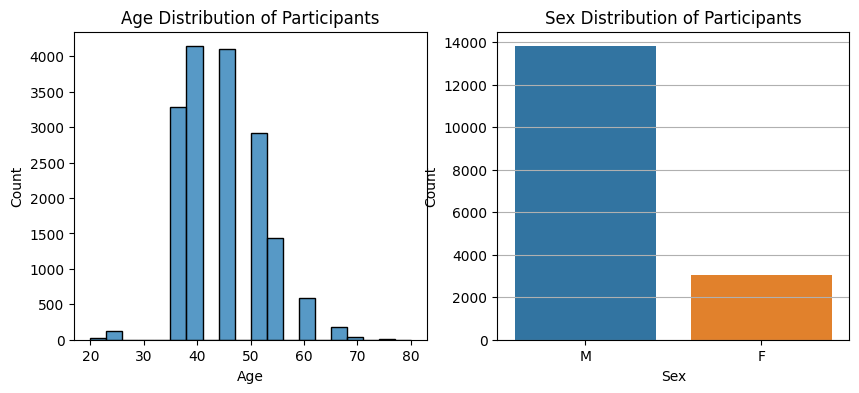

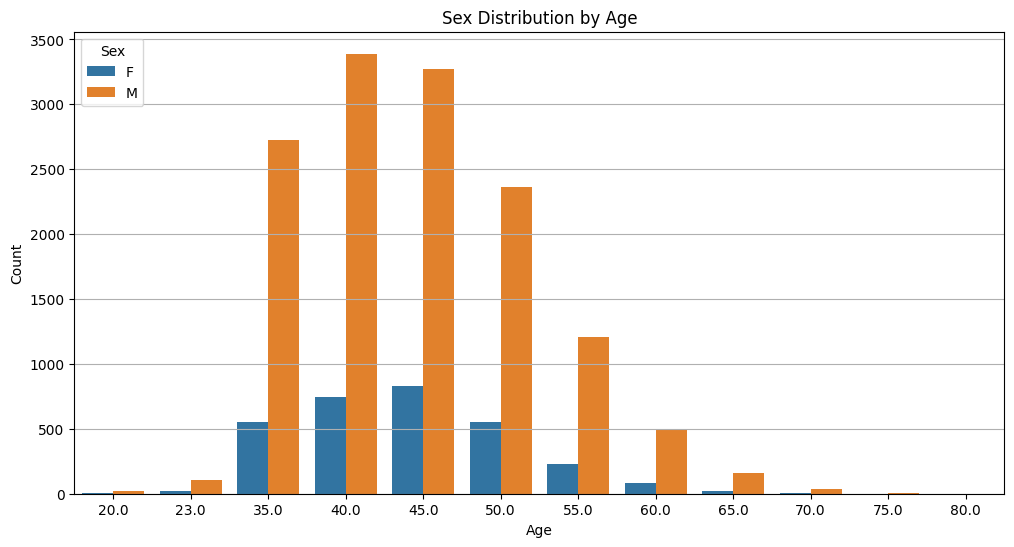

In [20]:
import matplotlib.pyplot as plt
import matplotlib.axes as ax
import seaborn as sns

plt.figure(figsize=(10, 4))

# Plotting the age distribution as a histogram
plt.subplot(1, 2, 1)
sns.histplot(data=runners, x='AGE', bins=20)
plt.xlabel('Age')
plt.ylabel('Count')
plt.title('Age Distribution of Participants')

sex_counts = runners['SEX'].value_counts()

plt.subplot(1, 2, 2)
plt.grid()
sns.barplot(x=sex_counts.index, y=sex_counts.values)
plt.xlabel('Sex')
plt.ylabel('Count')
plt.title('Sex Distribution of Participants')
plt.show()

plt.figure(figsize=(12, 6))
plt.grid()
sex_age_counts = runners.groupby(['SEX', 'AGE']).size().reset_index(name='Count')
sns.barplot(data=sex_age_counts, x='AGE', y='Count', hue='SEX')
plt.xlabel('Age')
plt.ylabel('Count')
plt.title('Sex Distribution by Age')
plt.legend(title='Sex')
plt.show()

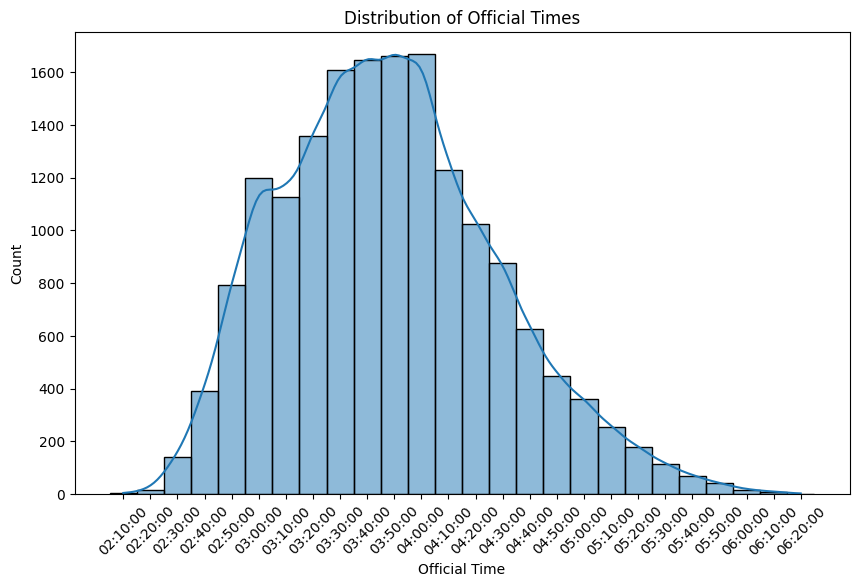

In [21]:
# Plotting the distribution of official times using a histogram
plt.figure(figsize=(10, 6))
sns.histplot(data=runners, x='TIME COMPARTMENT',kde=True)
plt.xlabel('Official Time')
plt.ylabel('Count')
plt.title('Distribution of Official Times')
plt.xticks(rotation=45)
plt.show()

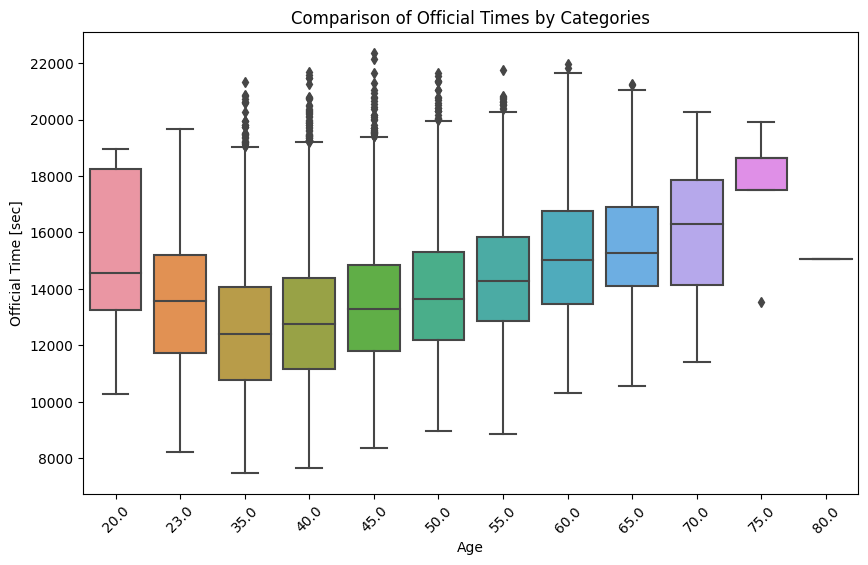

In [22]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=runners, x='AGE', y='OFFICIAL TIME')
plt.xlabel('Age')
plt.ylabel('Official Time [sec]')
plt.title('Comparison of Official Times by Categories')
plt.xticks(rotation=45)
plt.show()

## Shuffle data and create train and test sets

In [54]:
def shuffle_and_split_data(data, seperate_rate):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * seperate_rate)
    train_indices = shuffled_indices[test_set_size:]
    test_indices = shuffled_indices[:test_set_size]
    return data.iloc[train_indices], data.iloc[test_indices]

In [55]:
train_set, test_set = shuffle_and_split_data(runners, 0.2)

In [56]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, stratify=runners['SEX'], random_state=42)

In [57]:
features = runners.drop(['NAME', 'SEX', 'CATEGORY', 'TIME COMPARTMENT'], axis=1)
target = runners['SEX'].copy()

In [58]:
test_man = X_train[X_train['OFFICIAL POS.'].isin([18892])]

In [59]:
test_woman = X_train[X_train['OFFICIAL POS.'].isin([19745])]

# Select and Train a Model

### Create, train and test LogisticRegression Classifier

In [60]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import mean_squared_error

# Createa a Logisitc Regression Classifier
lgr_cls = LogisticRegression()
# Train the model on the training data
lgr_cls.fit(X_train, y_train)
# Make predictions on the train set
y_pred = lgr_cls.predict(X_test)
# Evalue the model's accuracy 
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.8166716107979828


In [61]:
lgr_cls.score(X_test, y_test)

0.8166716107979828

### Create, train and test LogisticRegression Classifier by adjusting the hyperparameters by GridSearch

In [62]:
from sklearn.model_selection import GridSearchCV

params = {
    'C': [0.01, 0.1, 1, 10, 100]
}
# Create a Logisitic Regression Classifier
lgr_cls = LogisticRegression()
# Create an instance of GridSearchCV with the classifier and parameter grid
grid_search = GridSearchCV(lgr_cls, params, cv=5, error_score='raise')
# Fit the grid search object to training data
grid_search.fit(X_train, y_train)
# Get the best hyperparameters found by grid search
print("Best Hyperparameters:", grid_search.best_params_)
# Get the best score found by grid search
best_score = grid_search.best_score_

#Create a new classifier with the best params and train the model
grid_search.best_estimator_.fit(X_train, y_train)
tuned_accuracy = grid_search.score(X_test, y_test)
tuned_accuracy

Best Hyperparameters: {'C': 0.01}


0.8166716107979828

### Create, train and test Support Vector Machine Classifier

In [30]:
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

# Create a pipeline based on scaler and suport vector machine classifier
svm_clf = make_pipeline(
    StandardScaler(),
    SVC()
)
# Train the pipeline on the training data
svm_clf.fit(X_train, y_train)
# Predict on the test set
y_pred = svm_clf.predict(X_test)
# Evalue the pipeline's accuracy 
accuracy_svm = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy_svm)

Accuracy: 0.8187481459507564


### Create, train and test SVM Classifier by adjusting the hyperparameters by GridSearch

In [89]:
from sklearn.pipeline import Pipeline

# Create a pipeline based on scaler and suport vector machine classifier
pipeline = make_pipeline(
    (StandardScaler()),  # Feature scaling
    (SVC())  # SVM classifier
)
# Define the parameter grid for GridSearchCV
param = {
    'svc__kernel': ['linear', 'rbf'],
    'svc__gamma': [0.1, 1, 10],
    'svc__C': [0.1, 1, 10]
}

# Create an instance of GridSearchCV with the pipeline
grid_search_svm = GridSearchCV(pipeline, param, cv=5, scoring='accuracy')
# Fit the data of perform grid search and hyperparameter tuning
grid_search_svm.fit(X_train, y_train)

# Print the best hyperparameters and best score
print("Best Hyperparameters:", grid_search_svm.best_params_)
print("Best Score:", grid_search_svm.best_score_)

Best Hyperparameters: {'svc__C': 10, 'svc__gamma': 0.1, 'svc__kernel': 'rbf'}
Best Score: 0.8190448448600434


In [ ]:
grid_search_svm.predict(X_test)

In [90]:
best_params_svc = grid_search_svm.best_params_

### Create, train and test RandomForest Classifier

In [32]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

# Create an instance of the Random Forest Classifier
rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1, random_state=42)
# Fit the classifier to the training data
rnd_clf.fit(X_train, y_train)
# Make predictions on the test set
rnd_clf.predict(X_test)
# Evaluate the performance
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, pos_label='M')
recall = recall_score(y_test, y_pred, pos_label='M')
f1 = f1_score(y_test, y_pred, pos_label='M')
# Perform cross-validation
cv_scores = cross_val_score(rnd_clf, X_test, y_test, cv=5, scoring='accuracy')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1)

# Print the cross-validation scores
print("Cross-Validation Scores:", cv_scores)
print("Mean Accuracy:", cv_scores.mean())
print("Standard Deviation:", cv_scores.std())

Accuracy: 0.8187481459507564
Precision: 0.8187481459507564
Recall: 1.0
F1-Score: 0.9003425216114826
Cross-Validation Scores: [0.80296296 0.8115727  0.81750742 0.82047478 0.81602374]
Mean Accuracy: 0.8137083195955599
Standard Deviation: 0.006092664917036803


In [99]:
best_params = {}
for x in best_params_svc.items():
    best_params[x[0].split('__')[1]] = x[1]

C 10
gamma 0.1
kernel rbf


{'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}

In [106]:
scores = []
for i in range(10):
    X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, stratify=runners['SEX'], random_state=i)
    pipeline = make_pipeline(
        StandardScaler(),
        SVC(**best_params)
    )
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    scores.append(accuracy_score(y_test, y_pred))

In [107]:
scores[np.argmax(scores)]

0.8193414417086918

# Predicting age based on the avaliable data 

In [101]:
participant_gender = runners[['SEX']]
participant_gender.head()

,SEX
4,M
16,M
28,M
29,M
37,M


In [102]:
sex_encoded = pd.get_dummies(runners['SEX'], prefix='SEX')

In [103]:
runners = pd.concat([runners, sex_encoded], axis=1)

In [104]:
runners

,OFFICIAL POS.,RACE NUMBER,NAME,OFFICIAL TIME,REAL TIME,REAL AVERAGE,CATEGORY,SEX,TIME COMPARTMENT,AGE,SEX_F,SEX_M
4,5.0,3,"ÖZBILEN, KAAN KIGEN",7476.0,7476.0,177.0,M-M35,M,02:10:00,35.0,0,1
16,17.0,10,"LAMDASSEM, AYAD",7659.0,7659.0,182.0,M-M40,M,02:10:00,40.0,0,1
28,29.0,38,"JIMENEZ VICENTE, ALEJANDRO",7854.0,7852.0,186.0,M-M35,M,02:20:00,35.0,0,1
29,30.0,19,"GUERRA, JAVIER",7920.0,7920.0,188.0,M-M35,M,02:20:00,35.0,0,1
37,38.0,942,"MAHIEU, JUSTIN",8016.0,8014.0,190.0,M-M35,M,02:20:00,35.0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
21621,21622.0,1424,"DABBAH, FABIAN",21748.0,21699.0,515.0,M-M55,M,06:10:00,55.0,0,1
21622,21623.0,26332,"GOFFIN, SOLANGE",21807.0,21723.0,517.0,F-W60,F,06:10:00,60.0,1,0
21624,21625.0,28127,"ARRIGHI, PAOLA",21961.0,21920.0,520.0,F-W60,F,06:10:00,60.0,1,0
21625,21626.0,5337,"ALLEN, ROXANA",22145.0,22115.0,525.0,F-W45,F,06:10:00,45.0,1,0


In [133]:
features = runners.drop(['NAME', 'CATEGORY', 'SEX', 'TIME COMPARTMENT', 'AGE'], axis=1)
target = runners['AGE'].copy()

In [134]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, stratify=runners['SEX'], random_state=42)

In [109]:
# Create a pipeline based on scaler and suport vector machine classifier
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Feature scaling
    ('svm', SVC())  # SVM classifier
])
# Define the parameter grid for GridSearchCV
param = {
    'svm__kernel': ['linear', 'rbf'],
    'svm__gamma': [0.1, 1, 10],
    'svm__C': [0.1, 1, 10]
}

# Create an instance of GridSearchCV with the pipeline
grid_search = GridSearchCV(pipeline, param, cv=5, scoring='accuracy')
# Fit the data of perform grid search and hyperparameter tuning
grid_search.fit(X_train, y_train)

# Print the best hyperparameters and best score
print("Best Hyperparameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

C:\Users\Adrian_PC\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Best Hyperparameters: {'svm__C': 0.1, 'svm__gamma': 1, 'svm__kernel': 'rbf'}
Best Score: 0.2707646093197299


In [139]:
# Create an instance of the Random Forest Classifier
rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1, random_state=42)
# Fit the classifier to the training data
rnd_clf.fit(X_train, y_train)
# Make predictions on the test set
rnd_clf.predict(X_test)
# Evaluate the performance
accuracy = accuracy_score(y_test, y_pred)
# Perform cross-validation
cv_scores = cross_val_score(rnd_clf, X_test, y_test, cv=5, scoring='accuracy')

# Print the cross-validation scores
print("Accuracy:", accuracy)
print("Cross-Validation Scores:", cv_scores)
print("Mean Accuracy:", cv_scores.mean())
print("Standard Deviation:", cv_scores.std())

C:\Users\Adrian_PC\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Accuracy: 0.26431326016018986
Cross-Validation Scores: [0.2637037  0.27002967 0.26557864 0.27744807 0.30267062]
Mean Accuracy: 0.2758861413342125
Standard Deviation: 0.014204244284225152
